Winter Break 2022 work. 

Run on jupyterhub-west.nrp-nautilus.io with a RTX A100 GPU.

Adapted from https://colab.research.google.com/github/ouhenio/StyleGAN3-CLIP-notebook/blob/main/StyleGAN3%2Binversion%2BCLIP.ipynb#scrollTo=5K38uyFrv5wo

# 0. Setup

One time install of libraries:

In [1]:
!pip install --upgrade torch==1.9.1+cu111 torchvision==0.10.1+cu111 -f https://download.pytorch.org/whl/torch_stable.html
#!pip install --upgrade https://download.pytorch.org/whl/nightly/cu111/torch-1.11.0.dev20211012%2Bcu111-cp37-cp37m-linux_x86_64.whl https://download.pytorch.org/whl/nightly/cu111/torchvision-0.12.0.dev20211012%2Bcu111-cp37-cp37m-linux_x86_64.whl
!git clone https://github.com/NVlabs/stylegan3
!git clone https://github.com/openai/CLIP
!pip install -e ./CLIP
!pip install einops ninja

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |██████████████████████████▉     | 1713.4 MB 144.9 MB/s eta 0:00:03

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



     |████████████████████████████████| 2041.3 MB 461 bytes/s           
     |████████████████████████████████| 20.5 MB 130.0 MB/s            
  Attempting uninstall: torch
    Found existing installation: torch 1.9.1
    Uninstalling torch-1.9.1:
      Successfully uninstalled torch-1.9.1
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.10.1
    Uninstalling torchvision-0.10.1:
      Successfully uninstalled torchvision-0.10.1
Cloning into 'stylegan3'...
remote: Enumerating objects: 193, done.
remote: Total 193 (delta 0), reused 0 (delta 0), pack-reused 193
Receiving objects: 100% (193/193), 4.18 MiB | 7.35 MiB/s, done.
Resolving deltas: 100% (86/86), done.
Cloning into 'CLIP'...
remote: Enumerating objects: 185, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 185 (delta 7), reused 13 (delta 4), pack-reused 168
Receiving objects: 100% (185/185), 8.90 MiB | 22.02 MiB/s, done.
Resolving

# 1. Session

In [2]:
import sys
sys.path.append('./CLIP')
sys.path.append('./stylegan3')

In [3]:
import io
import os, time
import pickle
import shutil
import numpy as np
import torch
import torch.nn.functional as F
import requests
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import clip
import copy
import imageio
import unicodedata
import re
from PIL import Image
from tqdm.notebook import tqdm
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from IPython.display import display
from einops import rearrange
# from google.colab import files
from time import perf_counter
from stylegan3.dnnlib.util import open_url

In [4]:
device = torch.device('cuda:0')

# Load VGG16 feature detector.
url = 'https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/metrics/vgg16.pt'
with open_url(url) as f:
    vgg16 = torch.jit.load(f).eval().to(device)
print('Using device:', device, file=sys.stderr)

Using device: cuda:0


## Necessary functions

In [6]:
def fetch(url_or_path):
    if str(url_or_path).startswith('http://') or str(url_or_path).startswith('https://'):
        r = requests.get(url_or_path)
        r.raise_for_status()
        fd = io.BytesIO()
        fd.write(r.content)
        fd.seek(0)
        return fd
    return open(url_or_path, 'rb')

def fetch_model(url_or_path):
    if "drive.google" in url_or_path:
      if "18MOpwTMJsl_Z17q-wQVnaRLCUFZYSNkj" in url_or_path: 
        basename = "wikiart-1024-stylegan3-t-17.2Mimg.pkl"
      elif "14UGDDOusZ9TMb-pOrF0PAjMGVWLSAii1" in url_or_path:
        basename = "lhq-256-stylegan3-t-25Mimg.pkl"
    else:
        basename = os.path.basename(url_or_path)
    if os.path.exists(basename):
        return basename
    else:
        if "drive.google" not in url_or_path:
          !wget -c '{url_or_path}'
        else:
          path_id = url_or_path.split("id=")[-1]
          !gdown --id '{path_id}'
        return basename

def slugify(value, allow_unicode=False):
    """
    Taken from https://github.com/django/django/blob/master/django/utils/text.py
    Convert to ASCII if 'allow_unicode' is False. Convert spaces or repeated
    dashes to single dashes. Remove characters that aren't alphanumerics,
    underscores, or hyphens. Convert to lowercase. Also strip leading and
    trailing whitespace, dashes, and underscores.
    """
    value = str(value)
    if allow_unicode:
        value = unicodedata.normalize('NFKC', value)
    else:
        value = unicodedata.normalize('NFKD', value).encode('ascii', 'ignore').decode('ascii')
    value = re.sub(r'[^\w\s-]', '', value.lower())
    return re.sub(r'[-\s]+', '-', value).strip('-_')

def norm1(prompt):
    "Normalize to the unit sphere."
    return prompt / prompt.square().sum(dim=-1,keepdim=True).sqrt()

def spherical_dist_loss(x, y):
    x = F.normalize(x, dim=-1)
    y = F.normalize(y, dim=-1)
    return (x - y).norm(dim=-1).div(2).arcsin().pow(2).mul(2)

class MakeCutouts(torch.nn.Module):
    def __init__(self, cut_size, cutn, cut_pow=1.):
        super().__init__()
        self.cut_size = cut_size
        self.cutn = cutn
        self.cut_pow = cut_pow

    def forward(self, input):
        sideY, sideX = input.shape[2:4]
        max_size = min(sideX, sideY)
        min_size = min(sideX, sideY, self.cut_size)
        cutouts = []
        for _ in range(self.cutn):
            size = int(torch.rand([])**self.cut_pow * (max_size - min_size) + min_size)
            offsetx = torch.randint(0, sideX - size + 1, ())
            offsety = torch.randint(0, sideY - size + 1, ())
            cutout = input[:, :, offsety:offsety + size, offsetx:offsetx + size]
            cutouts.append(F.adaptive_avg_pool2d(cutout, self.cut_size))
        return torch.cat(cutouts)

make_cutouts = MakeCutouts(224, 32, 0.5)

def embed_image(image):
  n = image.shape[0]
  cutouts = make_cutouts(image)
  embeds = clip_model.embed_cutout(cutouts)
  embeds = rearrange(embeds, '(cc n) c -> cc n c', n=n)
  return embeds

def embed_url(url):
  image = Image.open(fetch(url)).convert('RGB')
  return embed_image(TF.to_tensor(image).to(device).unsqueeze(0)).mean(0).squeeze(0)

class CLIP(object):
  def __init__(self):
    clip_model = "ViT-B/32"
    self.model, _ = clip.load(clip_model)
    self.model = self.model.requires_grad_(False)
    self.normalize = transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                                          std=[0.26862954, 0.26130258, 0.27577711])

  @torch.no_grad()
  def embed_text(self, prompt):
      "Normalized clip text embedding."
      return norm1(self.model.encode_text(clip.tokenize(prompt).to(device)).float())

  def embed_cutout(self, image):
      "Normalized clip image embedding."
      return norm1(self.model.encode_image(self.normalize(image)))
  
clip_model = CLIP()

# Projector

def project(
    G,
    target: torch.Tensor, # [C,H,W] and dynamic range [0,255], W & H must match G output resolution
    *,
    num_steps                  = 1000,
    w_avg_samples              = -1,
    initial_learning_rate      = 0.1,
    initial_noise_factor       = 0.05,
    lr_rampdown_length         = 0.25,
    lr_rampup_length           = 0.05,
    noise_ramp_length          = 0.75,
    regularize_noise_weight    = 1e5,
    verbose                    = False,
    device: torch.device
):

    assert target.shape == (G.img_channels, G.img_resolution, G.img_resolution)

    def logprint(*args):
        if verbose:
            print(*args)

    G = copy.deepcopy(G).eval().requires_grad_(False).to(device) # type: ignore

    # Compute w stats.
    if w_avg_samples > 0:
      logprint(f'Computing W midpoint and stddev using {w_avg_samples} samples...')
      z_samples = np.random.RandomState(123).randn(w_avg_samples, G.z_dim)
    else:
      seed = np.random.randint(0, 2**32 - 1)
      z_samples = np.random.RandomState(seed).randn(1, G.z_dim)
    w_samples = G.mapping(torch.from_numpy(z_samples).to(device), None)  # [N, L, C]
    w_samples = w_samples[:, :1, :].cpu().numpy().astype(np.float32)       # [N, 1, C]
    w_avg = np.mean(w_samples, axis=0, keepdims=True)      # [1, 1, C]
    w_std = (np.sum((w_samples - w_avg) ** 2) / w_avg_samples) ** 0.5

    # Setup noise inputs.
    noise_bufs = { name: buf for (name, buf) in G.synthesis.named_buffers() if 'noise_const' in name }

    # Features for target image.
    target_images = target.unsqueeze(0).to(device).to(torch.float32)
    if target_images.shape[2] > 256:
        target_images = F.interpolate(target_images, size=(256, 256), mode='area')
    target_features = vgg16(target_images, resize_images=False, return_lpips=True)

    w_opt = torch.tensor(w_avg, dtype=torch.float32, device=device, requires_grad=True) # pylint: disable=not-callable
    w_out = torch.zeros([num_steps] + list(w_opt.shape[1:]), dtype=torch.float32, device=device)
    optimizer = torch.optim.Adam([w_opt] + list(noise_bufs.values()), betas=(0.9, 0.999), lr=initial_learning_rate)

    # Init noise.
    for buf in noise_bufs.values():
        buf[:] = torch.randn_like(buf)
        buf.requires_grad = True

    for step in range(num_steps):
        # Learning rate schedule.
        t = step / num_steps
        w_noise_scale = w_std * initial_noise_factor * max(0.0, 1.0 - t / noise_ramp_length) ** 2
        lr_ramp = min(1.0, (1.0 - t) / lr_rampdown_length)
        lr_ramp = 0.5 - 0.5 * np.cos(lr_ramp * np.pi)
        lr_ramp = lr_ramp * min(1.0, t / lr_rampup_length)
        lr = initial_learning_rate * lr_ramp
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr

        # Synth images from opt_w.
        w_noise = torch.randn_like(w_opt) * w_noise_scale
        ws = (w_opt + w_noise).repeat([1, G.mapping.num_ws, 1])
        synth_images = G.synthesis(ws, noise_mode='const')

        # Downsample image to 256x256 if it's larger than that. VGG was built for 224x224 images.
        synth_images = (synth_images + 1) * (255/2)
        if synth_images.shape[2] > 256:
            synth_images = F.interpolate(synth_images, size=(256, 256), mode='area')

        # Features for synth images.
        synth_features = vgg16(synth_images, resize_images=False, return_lpips=True)
        dist = (target_features - synth_features).square().sum()

        # Noise regularization.
        reg_loss = 0.0
        for v in noise_bufs.values():
            noise = v[None,None,:,:] # must be [1,1,H,W] for F.avg_pool2d()
            while True:
                reg_loss += (noise*torch.roll(noise, shifts=1, dims=3)).mean()**2
                reg_loss += (noise*torch.roll(noise, shifts=1, dims=2)).mean()**2
                if noise.shape[2] <= 8:
                    break
                noise = F.avg_pool2d(noise, kernel_size=2)
        loss = dist + reg_loss * regularize_noise_weight

        # Step
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()
        logprint(f'step {step+1:>4d}/{num_steps}: dist {dist:<4.2f} loss {float(loss):<5.2f}')

        # Save projected W for each optimization step.
        w_out[step] = w_opt.detach()[0]

        # Normalize noise.
        with torch.no_grad():
            for buf in noise_bufs.values():
                buf -= buf.mean()
                buf *= buf.square().mean().rsqrt()

    return w_out.repeat([1, G.mapping.num_ws, 1])

def get_perceptual_loss(synth_image, target_features):
    # Downsample image to 256x256 if it's larger than that. VGG was built for 224x224 images.
    synth_image = (synth_image + 1) * (255/2)
    if synth_image.shape[2] > 256:
        synth_image = F.interpolate(synth_image, size=(256, 256), mode='area')

    # Features for synth images.
    synth_features = vgg16(synth_image, resize_images=False, return_lpips=True)
    return (target_features - synth_features).square().sum()

def get_target_features(target):
    target_images = target.unsqueeze(0).to(device).to(torch.float32)
    if target_images.shape[2] > 256:
        target_images = F.interpolate(target_images, size=(256, 256), mode='area')
    return vgg16(target_images, resize_images=False, return_lpips=True)

Install gdown and use it to download model file

In [8]:
!pip install gdown

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing wheel metadata (pyproject.toml) ... done
  Created wheel for gdown: filename=gdown-4.2.0-py3-none-any.whl size=14262 sha256=5e8d25b76800fa899ecf10d216a57f6e0140a5b4fe5a7576a822cff1f6441a43
  Stored in directory: /home/jovyan/.cache/pip/wheels/68/11/97/886e5796b655bf28bf4a0d75e933ea71c6d7d34be701168d1d
Successfully built gdown


In [9]:
!gdown --id 18MOpwTMJsl_Z17q-wQVnaRLCUFZYSNkj

Downloading...
From: https://drive.google.com/uc?id=18MOpwTMJsl_Z17q-wQVnaRLCUFZYSNkj
To: /home/jovyan/cohab-ml-imagination/wikiart-1024-stylegan3-t-17.2Mimg.pkl
100%|████████████████████████████████████████| 295M/295M [00:11<00:00, 25.9MB/s]


Model selection:

In [11]:
base_url = "https://api.ngc.nvidia.com/v2/models/nvidia/research/stylegan3/versions/1/files/"

Model = 'Wikiart' #@param ["FFHQ", "MetFaces", "AFHQv2", "cosplay", "Wikiart", "Landscapes"]

model_name = {
    "FFHQ": base_url + "stylegan3-t-ffhqu-1024x1024.pkl",
    "MetFaces": base_url + "stylegan3-r-metfacesu-1024x1024.pkl",
    "AFHQv2": base_url + "stylegan3-t-afhqv2-512x512.pkl",
    "cosplay": "https://l4rz.net/cosplayface-snapshot-stylegan3t-008000.pkl",
    "Wikiart": "https://drive.google.com/u/0/open?id=18MOpwTMJsl_Z17q-wQVnaRLCUFZYSNkj",
    "Landscapes": "https://drive.google.com/u/0/open?id=14UGDDOusZ9TMb-pOrF0PAjMGVWLSAii1"
}

# network_url = model_name[Model]
model_path = "wikiart-1024-stylegan3-t-17.2Mimg.pkl"
# with open(fetch_model(network_url), 'rb') as fp:

with open(model_path, 'rb') as fp:
  G = pickle.load(fp)['G_ema'].to(device)

zs = torch.randn([10000, G.mapping.z_dim], device=device)
w_stds = G.mapping(zs, None).std(0)

Setting up PyTorch plugin "bias_act_plugin"... Done.


## Parameters for Text to Image Translation

In [12]:
target_image_filename = "Red_Blossom_Cropped.jpg" #@param {type:"string"}
text = "" #@param {type:"string"}
loss_ratio = 0.4#@param {type:"number"}
steps = 800 #@param {type:"number"}
limit_step = 600 #@param {type:"number"}
seed = 34 # 14 default #@param {type:"number"}

if seed == -1:
    seed = np.random.randint(0,9e9)

target = clip_model.embed_text(text)

target_pil = Image.open(target_image_filename).convert('RGB')
w, h = target_pil.size
s = min(w, h)
target_pil = target_pil.crop(((w - s) // 2, (h - s) // 2, (w + s) // 2, (h + s) // 2))
target_pil = target_pil.resize((G.img_resolution, G.img_resolution), Image.LANCZOS)
target_uint8 = np.array(target_pil, dtype=np.uint8)
target_tensor = torch.tensor(target_uint8.transpose([2, 0, 1]), device=device)

## Run the model

Setting up PyTorch plugin "filtered_lrelu_plugin"... Done.


  0%|          | 0/800 [00:00<?, ?it/s]

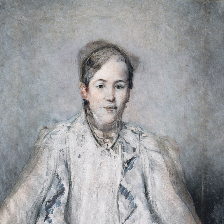

image 0/800 | projector loss: 0.8018413782119751 | clip loss: 0.9386885166168213 | modulated loss: 0.8018413782119751


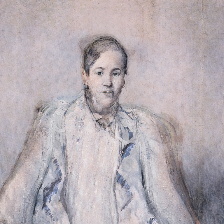

image 10/800 | projector loss: 0.6635086536407471 | clip loss: 0.9235955476760864 | modulated loss: 0.6527067422866821


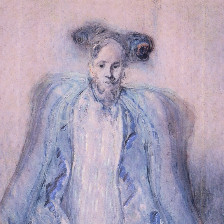

image 20/800 | projector loss: 0.6325864791870117 | clip loss: 0.8889403343200684 | modulated loss: 0.6124879717826843


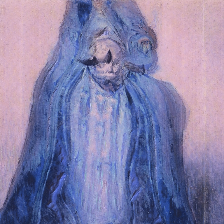

image 30/800 | projector loss: 0.5921123623847961 | clip loss: 0.8935632705688477 | modulated loss: 0.5647406578063965


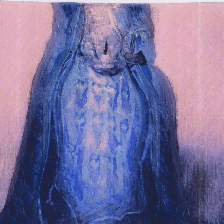

image 40/800 | projector loss: 0.5835206508636475 | clip loss: 0.8871400356292725 | modulated loss: 0.5485621094703674


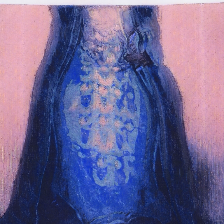

image 50/800 | projector loss: 0.5916779041290283 | clip loss: 0.8779416084289551 | modulated loss: 0.548468291759491


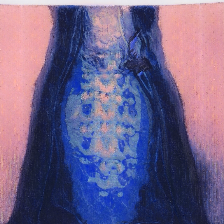

image 60/800 | projector loss: 0.5526782870292664 | clip loss: 0.8916112780570984 | modulated loss: 0.5063265562057495


In [ ]:
# Actually do the run

tf = Compose([
  Resize(224),
  lambda x: torch.clamp((x+1)/2,min=0,max=1),
])


def run(timestring, projection_target):
  torch.manual_seed(seed)

  target_features = get_target_features(projection_target)

  # Init
  # Sample 32 inits and choose the one closest to prompt

  with torch.no_grad():
    qs = []
    losses = []
    for _ in range(8):
      q = (G.mapping(torch.randn([4,G.mapping.z_dim], device=device), None, truncation_psi=0.7) - G.mapping.w_avg) / w_stds
      images = G.synthesis(q * w_stds + G.mapping.w_avg)
      loss = get_perceptual_loss(images, target_features)
      i = torch.argmin(loss)
      qs.append(q[i])
      losses.append(loss)
    qs = torch.stack(qs)
    losses = torch.stack(losses)
    i = torch.argmin(losses)
    q = qs[i].unsqueeze(0).requires_grad_()

  # Sampling loop
  q_ema = q
  opt = torch.optim.AdamW([q], lr=0.03, betas=(0.0,0.999))
  loop = tqdm(range(steps))
  for i in loop:
    opt.zero_grad()
    w = q * w_stds
    image = G.synthesis(w + G.mapping.w_avg, noise_mode='const')
    embed = embed_image(image.add(1).div(2))
    step_ratio = i / limit_step
    perceptual_loss = get_perceptual_loss(image, target_features)
    modulated_perceptual_loss = (
        max(loss_ratio, 1 - step_ratio)
        * get_perceptual_loss(image, target_features)
    )
    clip_loss = spherical_dist_loss(embed, target).mean()
    modulated_clip_loss = (
        min(1 - loss_ratio, step_ratio)
        * (step_ratio) * spherical_dist_loss(embed, target).mean()
    )
    loss = modulated_perceptual_loss + modulated_clip_loss
    loss.backward()
    opt.step()
    loop.set_postfix(loss=loss.item(), q_magnitude=q.std().item())

    q_ema = q_ema * 0.9 + q * 0.1
    image = G.synthesis(q_ema * w_stds + G.mapping.w_avg, noise_mode='const')

    if i % 10 == 0:
      display(TF.to_pil_image(tf(image)[0]))
      print(f"image {i}/{steps} | projector loss: {perceptual_loss} | clip loss: {clip_loss} | modulated loss: {loss}")
    pil_image = TF.to_pil_image(image[0].add(1).div(2).clamp(0,1))
    os.makedirs(f'samples/{timestring}', exist_ok=True)
    pil_image.save(f'samples/{timestring}/{i:04}.jpg')

try:
  timestring = time.strftime('%Y%m%d%H%M%S')
  run(timestring, target_tensor)
except KeyboardInterrupt:
  pass

## Save files

download the tar file created by this step manually

In [ ]:
#@markdown #**Save images** 📷
#@markdown A `.tar` file will be saved inside *samples* and automatically downloaded, unless you previously ran the Google Drive cell,
#@markdown in which case it'll be saved inside your previously created drive *samples* folder.

archive_name = "optional"#@param {type:"string"}

archive_name = slugify(archive_name)

if archive_name != "optional":
  fname = archive_name
  # os.rename(f'samples/{timestring}', f'samples/{fname}')
else:
  fname = timestring
# Save images as a tar archive
!tar cf samples/{fname}.tar samples/{timestring}

## requires the google files extension
# if os.path.isdir('drive/MyDrive/samples'):
#   shutil.copyfile(f'samples/{fname}.tar', f'drive/MyDrive/samples/{fname}.tar')
# else:
#   files.download(f'samples/{fname}.tar')

## Make a video

In [ ]:
#@markdown You can edit frame rate and stuff by double-clicking this tab.

frames = os.listdir(f"samples/{timestring}")
frames = len(list(filter(lambda filename: filename.endswith(".jpg"), frames))) #Get number of jpg generated

init_frame = 1 #This is the frame where the video will start
last_frame = frames #You can change i to the number of the last frame you want to generate. It will raise an error if that number of frames does not exist.

min_fps = 10
max_fps = 60

total_frames = last_frame-init_frame

#Desired video time in seconds
video_length = 14 #@param {type:"number"}
#Video filename
video_name = "" #@param {type:"string"}
video_name = slugify(video_name)

# frames = []
# tqdm.write('Generating video...')
# for i in range(init_frame,last_frame): #
#     filename = f"samples/{timestring}/{i:04}.jpg"
#     frames.append(Image.open(filename))

fps = np.clip(total_frames/video_length,min_fps,max_fps)

!ffmpeg -r {fps} -i samples/{timestring}/%04d.jpg -c:v libx264 -vf fps={fps} -pix_fmt yuv420p samples/{video_name}.mp4 -frames:v {total_frames}

# from subprocess import Popen, PIPE
# p = Popen(['ffmpeg', '-y', '-f', 'image2pipe', '-vcodec', 'png', '-r', str(fps), '-i', '-', '-vcodec', 'libx264', '-r', str(fps), '-pix_fmt', 'yuv420p', '-crf', '17', '-preset', 'veryslow', f'samples/{video_name}.mp4'], stdin=PIPE)
# for im in tqdm(frames):
#     im.save(p.stdin, 'PNG')
# p.stdin.close()

print("The video is now being compressed, wait...")
p.wait()
print("The video is ready")